In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from cgmsquared import clustering as cgm2_cluster
import haloclustering.evalulate_model as evaluate
import emcee
import corner
import pandas as pd
import scipy.special as sc
from astropy.cosmology import Planck15 as cosmo
import haloclustering.plot as hplt
import haloclustering.data as datamodule

from multiprocessing import Pool
from multiprocessing import cpu_count


plt.rcParams['font.serif'] = "DejaVu Serif"
plt.rcParams['font.family'] = "serif"

plt.rcParams['mathtext.fontset']='stix'
plt.rcParams['font.size'] = 16
from haloclustering import models


 $ G(r)^{1h} = A e^{(r/\sigma)^2}$

 $ \xi(r)^{2h} = (r/r_0)^{-\gamma}$ 

 $ r = \sqrt{s^2 + r_{\perp}^2} $

 $\chi_{\perp} \approx \int \max{(G(r), \xi(r))} ds$

 $ \sigma(A, r0, \gamma, r_c)$ where r_c is the crossing point

 
$s_{\rm cross} = \sqrt{\max{(r^2 - r_{\perp}^2}, 0)}$ 

$\int_0^{s_{eval}} G^{1h} + [\int_0^{s_{max}}\xi^{2h} - \int_0^{s_{eval}}\xi^{2h}]$

$\chi_{\perp}$ = norm_factor * ($\int_0^{s_{eval}} G^{1h} + [\rm{antidiv_{max}} - \rm{antidiv_{eval}}])$

and we can use `anti_derivative_full` for the 2h-terms

In [2]:
# get data
df = pd.read_csv('../data/cgm2_casbah_velo_split_table_with_comoving_rho_and_mass.csv')
df['log_rho'] = np.log10(df.rho)
df.sort_values('rho', inplace=True)
df.rho = df.rho / 1000 # convert to Mpc
df = df.query("(HM_0_500 != 'indeterminate') & (7 < mstars < 12)")
df['Hz'] = cosmo.H(df.z).value
vmax = 500.0 # km/s

df.dropna(subset=['mstars'], inplace=True)
massmask = df.eval("8 < mstars < 10.5").values
df.mstars = 10**df.mstars

outcomes = df.HM_0_500
hits = (outcomes.values == "hit") & massmask
misses = (outcomes.values == "miss") & massmask

In [3]:
df.loc[(df.mstars > 10**8), 'mstars']

0       6.937474e+08
2       9.364114e+10
3       8.063705e+09
4       1.919739e+11
5       9.130593e+09
            ...     
7387    5.164852e+10
7388    2.014072e+08
7389    3.385574e+10
7390    1.806679e+09
7391    5.464199e+08
Name: mstars, Length: 6984, dtype: float64

In [4]:
def g1h(r, A, sigma):
    return A * np.exp(-r**2 / (2*sigma**2))

def xi2h(r, r0, gamma):
    return (r/r0)**-gamma

def sigma_rc(rc, r0, A, gamma):
    return rc/np.sqrt(np.log(1/A)) - gamma*np.log(rc/r0)

def anti_derivative_full(r0, gamma, r_parallel, r_perpendicular):
    """
    This is the analytic solution to the integrand.

    see the solution at https://www.wolframalpha.com/input/?i=integral+%28sqrt%28x%5E2+%2B+r%5E2%29%2Fr0%29%5E-g


    Args:
        r0: scale length in comoving Mpc
        gamma: power law term.
        r_parallel: the integrand
        r_perpendicular: the rho_comoving_mpc measurements from the galaxies

    Returns:
        full: the anti-derivative

    """
    x = r_parallel
    r = r_perpendicular
    g = gamma
    full = (
        (x * (np.sqrt(r ** 2 + x ** 2) / r0) ** (-g))
        * (1 + x ** 2 / r ** 2) ** (g / 2)
        * sc.hyp2f1(1 / 2, g / 2, 3 / 2, -(x ** 2) / r ** 2)
    )
    return full

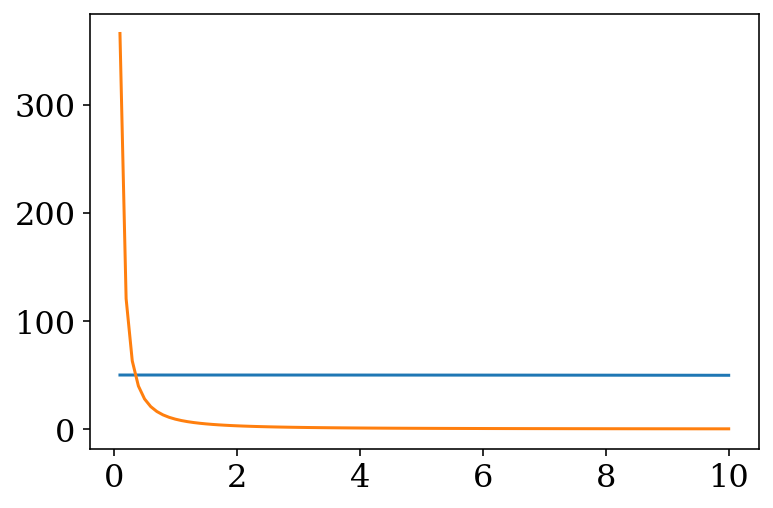

In [5]:
rlin = np.linspace(0.1, 10, 100)

plt.plot(rlin, g1h(rlin, 50, 100))
plt.plot(rlin, xi2h(rlin, 4, 1.6));

$\int_0^S e^{(-(ρ^2 + s^2)/(2 σ^2))} ds = \sqrt{π/2} σ e^{(-ρ^2/(2 σ^2))} erf(S/(\sqrt{2} σ))$

In [6]:
def anti_derivative_full(r0, gamma, r_parallel, r_perpendicular):
    """
    This is the analytic solution to the integrand.

    see the solution at https://www.wolframalpha.com/input/?i=integral+%28sqrt%28x%5E2+%2B+r%5E2%29%2Fr0%29%5E-g


    Args:
        r0: scale length in comoving Mpc
        gamma: power law term.
        r_parallel: the integrand
        r_perpendicular: the rho_comoving_mpc measurements from the galaxies

    Returns:
        full: the anti-derivative

    """
    x = r_parallel
    r = r_perpendicular
    g = gamma
    full = (
        (x * (np.sqrt(r ** 2 + x ** 2) / r0) ** (-g))
        * (1 + x ** 2 / r ** 2) ** (g / 2)
        * sc.hyp2f1(1 / 2, g / 2, 3 / 2, -(x ** 2) / r ** 2)
    )
    return full

def integral_1h(rho, A, sigma, s_eval):
    part1 = np.sqrt(np.pi/2) * sigma * np.exp(-rho**2/(2*sigma**2))
    part2 = sc.erf(s_eval/(np.sqrt(2)*sigma))
    return A * part1 * part2

def integral_2h(rho, s_max, s_eval, r0, gamma):
    part1 = anti_derivative_full(r0, gamma, s_max, rho) # Mpc
    part2 = anti_derivative_full(r0, gamma, s_eval, rho) # Mpc
    return part1 - part2

def chi_perp(r0, gamma, A, sigma, r_cross, rho_gal_com, z_gal, Hz, vmax):
    dv = vmax  # km/s
    a = 1 / (1 + z_gal)
    norm_const = a * Hz / (2 * dv)  # 1/Mpc
    s_max = dv / (a * Hz)  # Mpc
    s_cross = np.sqrt(np.maximum(r_cross**2 - rho_gal_com**2, 0))
    s_eval = np.minimum(s_max, s_cross)
    integrand = integral_1h(rho_gal_com, A, sigma, s_eval) + integral_2h(rho_gal_com, s_max, s_eval, r0, gamma)
    chi = norm_const * integrand
    return chi

def _choose_rc(rc, A, r0, gamma):
    """ Choose which crossing to use.

    Args:
        rc (_type_): _description_
        A (_type_): _description_
        r0 (_type_): _description_
        gamma (_type_): _description_

    Returns:
        _type_: _description_
    """
    deriv = 2*np.log(A) + gamma*(2*np.log(rc/r0) - 1)
    if np.all(deriv > 0):
        return rc
    else:
        return None

def _calc_sig(rc, A, r0, gamma):
    r = _choose_rc(rc, A, r0, gamma)
    if r is None:
        return None
    else:
        sig = 0.5*r**2 / (np.log(A) + gamma*(np.log(r/r0)))
        return np.sqrt(sig)

def mean_dNdz(z, dndz_index, dndz_coeff, vmax=500.0):
    # dN_dz for HI with logNHI > 14
    ion_lz = cgm2_cluster.hi_lz(
        z, danforth=False, gamma=dndz_index, coeff=dndz_coeff
    )
    clight = 299792.458
    # mean number of absorbers along line of sight in dz window
    dz = 2 * (1 + z) * (vmax / clight)
    mean_dN_dz = ion_lz * dz  # ~ (1+z)^3.3
    return mean_dN_dz

def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross

def r0_beta(r0, beta2h, mass, m0= 10**9.5):
    r0 = r0*(mass/m0) ** beta2h
    return r0


def phit(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass):
    r_cross = r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5)
    r0 = r0_beta(r0, beta2h, mass, m0= 10**9.5)
    sigma = _calc_sig(r_cross, A, r0, gamma)
    if sigma is None:
        return None
    chi = chi_perp(r0, gamma, A, sigma, r_cross, rho_gal_com, z_gal, Hz, vmax)
    dndz = mean_dNdz(z_gal, dndz_index, dndz_coeff)
    phit = 1 - np.exp(-(1 + chi)*dndz)
    phit = np.clip(phit, 0.00001, 0.99)
    return phit

def log_likelihood(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass, hits, misses):
    prob_hit = phit(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass)
    if prob_hit is None:
        return -np.inf, np.full(mass.shape, np.nan)
    else:
        prob_miss = 1 - prob_hit
        log_prob_hits = np.log(prob_hit[hits])
        log_prob_miss = np.log(prob_miss[misses])

        sum_log_prob_miss = np.sum(log_prob_miss)
        sum_log_prob_hits = np.sum(log_prob_hits)

        llikelihood = sum_log_prob_hits + sum_log_prob_miss
        return llikelihood, prob_hit

def log_prior(params):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params

    # flat prior on r0, gaussian prior on gamma around 1.6
    if (r0 < 0) or (r0 > 1000) or (r_cross < 0) or (r_cross > 1000):
        return -np.inf
    if (gamma < 0) or (gamma > 100):
        return -np.inf
    if (A < 0) or (A > 5000):
        return -np.inf  
    if (beta1h < 0) or (beta1h > 10) or (beta2h < -3) or (beta2h > 10):
        return -np.inf
    if (
        (dndz_index < -3)
        or (dndz_index > 3)
        or (dndz_coeff < 0)
        or (dndz_coeff > 100)
    ):
        return -np.inf

    sig = 1.0
    # TODO: check other priors for gamma 1-halo
    # ln_prior = -0.5 * ((gamma - 2) ** 2 / (sig) ** 2)
    ln_prior = -0.5 * ((gamma - 1.7) ** 2 / (0.1) ** 2)  # tejos 2014

    # ln_prior += -0.5 * ((r0 - 1) ** 2 / (sig) ** 2)
    ln_prior += -0.5 * ((r0 - 3.8) ** 2 / (0.3) ** 2)  # tejos 2014
    # ln_prior += -0.5*((beta - 0.5)**2/(sig)**2)

    #ln_prior += -0.5 * ((beta - 1 / 8) ** 2 / (sig) ** 2)  # mirror rvir slope
    #ln_prior += -0.5 * ((beta2h - 0) ** 2 / (sig) ** 2)  # no mass dependence?
    ln_prior += -0.5 * ((dndz_index - 0.97) ** 2 / (0.87) ** 2)  # kim+
    ln_prior += -0.5 * (
        (np.log(dndz_coeff) - np.log(10) * 1.25) ** 2 / (np.log(10) * 0.11) ** 2
    ) - np.log(
        dndz_coeff
    )  # kim+

    return ln_prior

def log_probability(params, rho_gal_com, z_gal, Hz, vmax, hits, misses, mass):
    r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff = params
    lp = log_prior(params)

    if not np.isfinite(lp):
        return -np.inf, np.full(mass.shape, np.nan)
    logl, prob_hit = log_likelihood(r0, gamma, beta2h, A, r_cross, beta1h, dndz_index, dndz_coeff, rho_gal_com, z_gal, Hz, vmax, mass, hits, misses)
    logprob = lp + logl
    return logprob, prob_hit

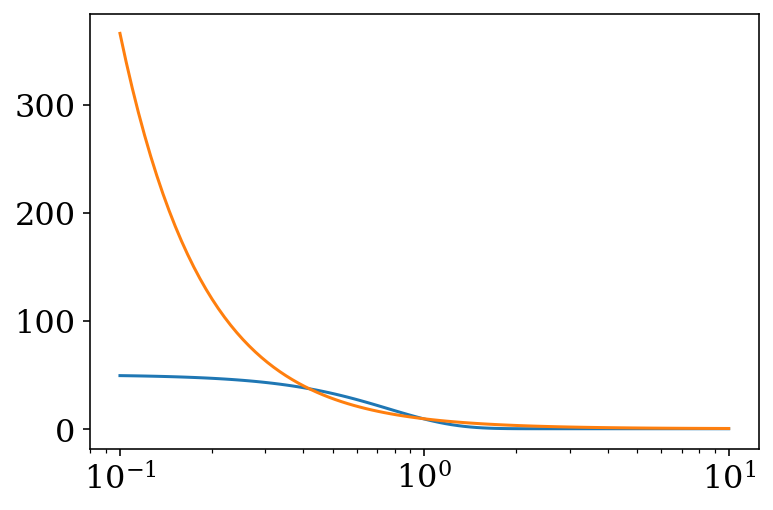

In [7]:
rlin = np.geomspace(0.1, 10, 100)

plt.plot(rlin, g1h(rlin, 50, 0.54))
plt.plot(rlin, xi2h(rlin, 4, 1.6));
plt.xscale('log')
# plt.yscale('log')

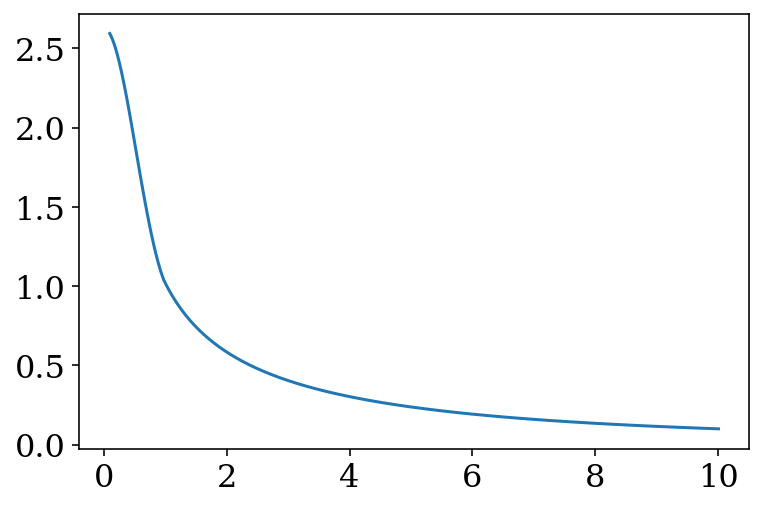

In [8]:
plt.plot(rlin, chi_perp(4, 1.6, 50, 0.54, 1, rlin, 0.2, 74, 500));

$\int_0^{s_{eval}} G^{1h} + [\int_0^{s_{max}}\xi^{2h} - \int_0^{s_{eval}}\xi^{2h}]$

In [9]:
initial = np.array([3.7, 1.6, 0.5, 500, 1.0, 0.5, 1.97, 19])


ncpu = cpu_count()
print("{0} CPUs".format(ncpu))

with Pool() as pool:
    sampler = evaluate.posterior_sampler(initial, log_probability, nsteps=4000, solnisobject=False, args=(df.rho.values, df.z.values, df.Hz.values, vmax, hits, misses, df.mstars.values))

8 CPUs


100%|██████████| 4000/4000 [03:38<00:00, 18.33it/s]


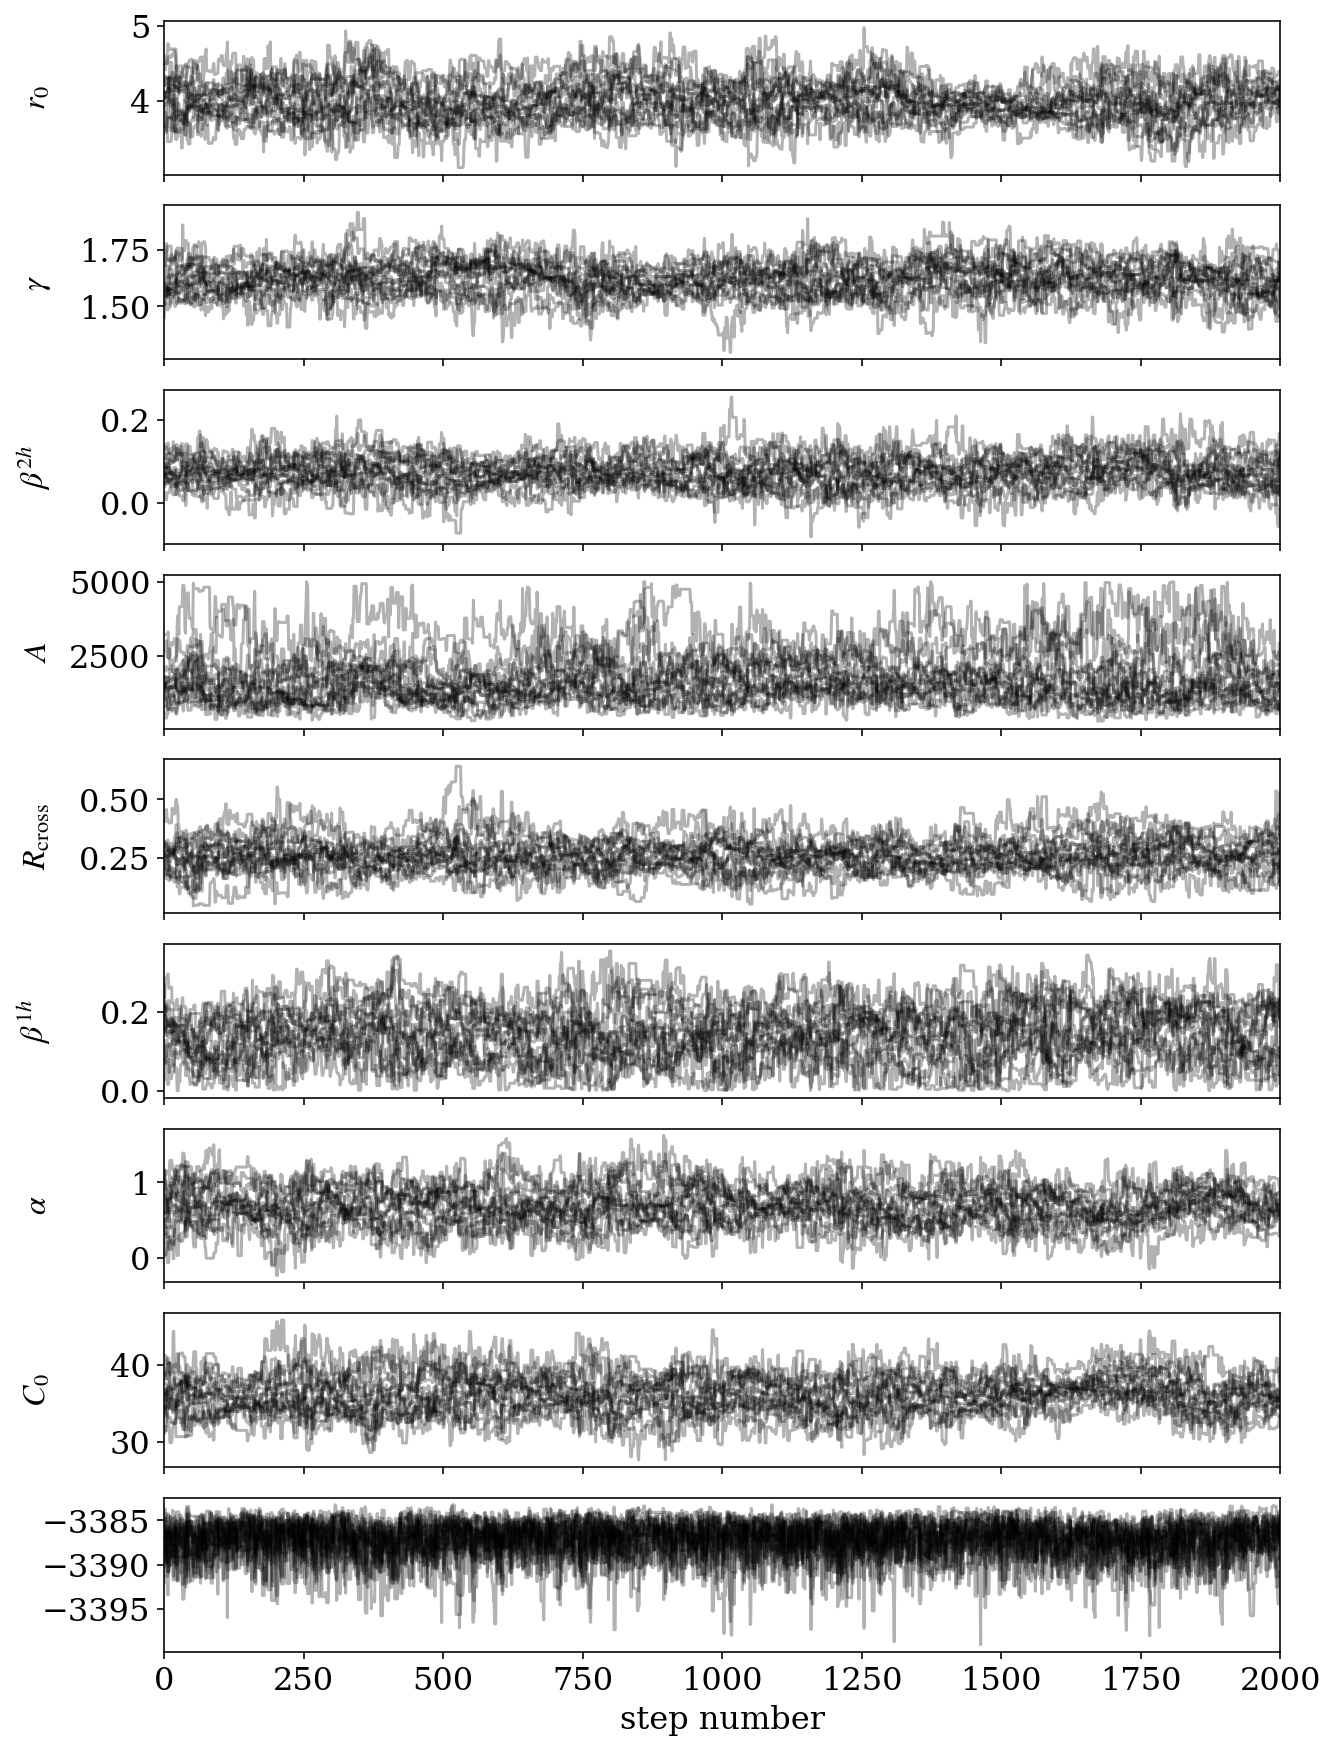

In [10]:
discard = 2000
samples = sampler.get_chain(discard=discard)
flat_samples = sampler.get_chain(discard=discard, thin=1, flat=True)

ndim = samples.shape[2]

# plot
fig, axes = plt.subplots(nrows=ndim+1, figsize=(10, 15), sharex=True)
labels = [r"$r_{0}$", r"$\gamma$", r"$\beta^{2h}$", r"$A$", r"$R_{\rm cross}$", r"$\beta^{1h}$", r"$\alpha$", r'$C_0$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

axes[-1].plot(sampler.lnprobability.T[discard:], "k", alpha=0.3);

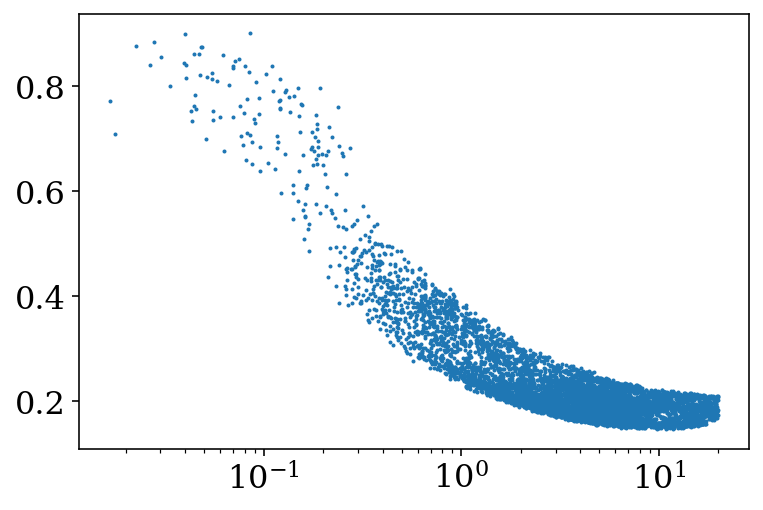

In [11]:
r0, gamma, beta2, A, r_cross, beta1, dndz_index, dndz_coeff = flat_samples[-55]
prob_hit = phit(r0, gamma, beta2, A, r_cross, beta1, dndz_index, dndz_coeff, df.rho.values, df.z.values, df.Hz, 500, df.mstars.values)
plt.scatter(df.rho, prob_hit, s=1)
plt.xscale('log')

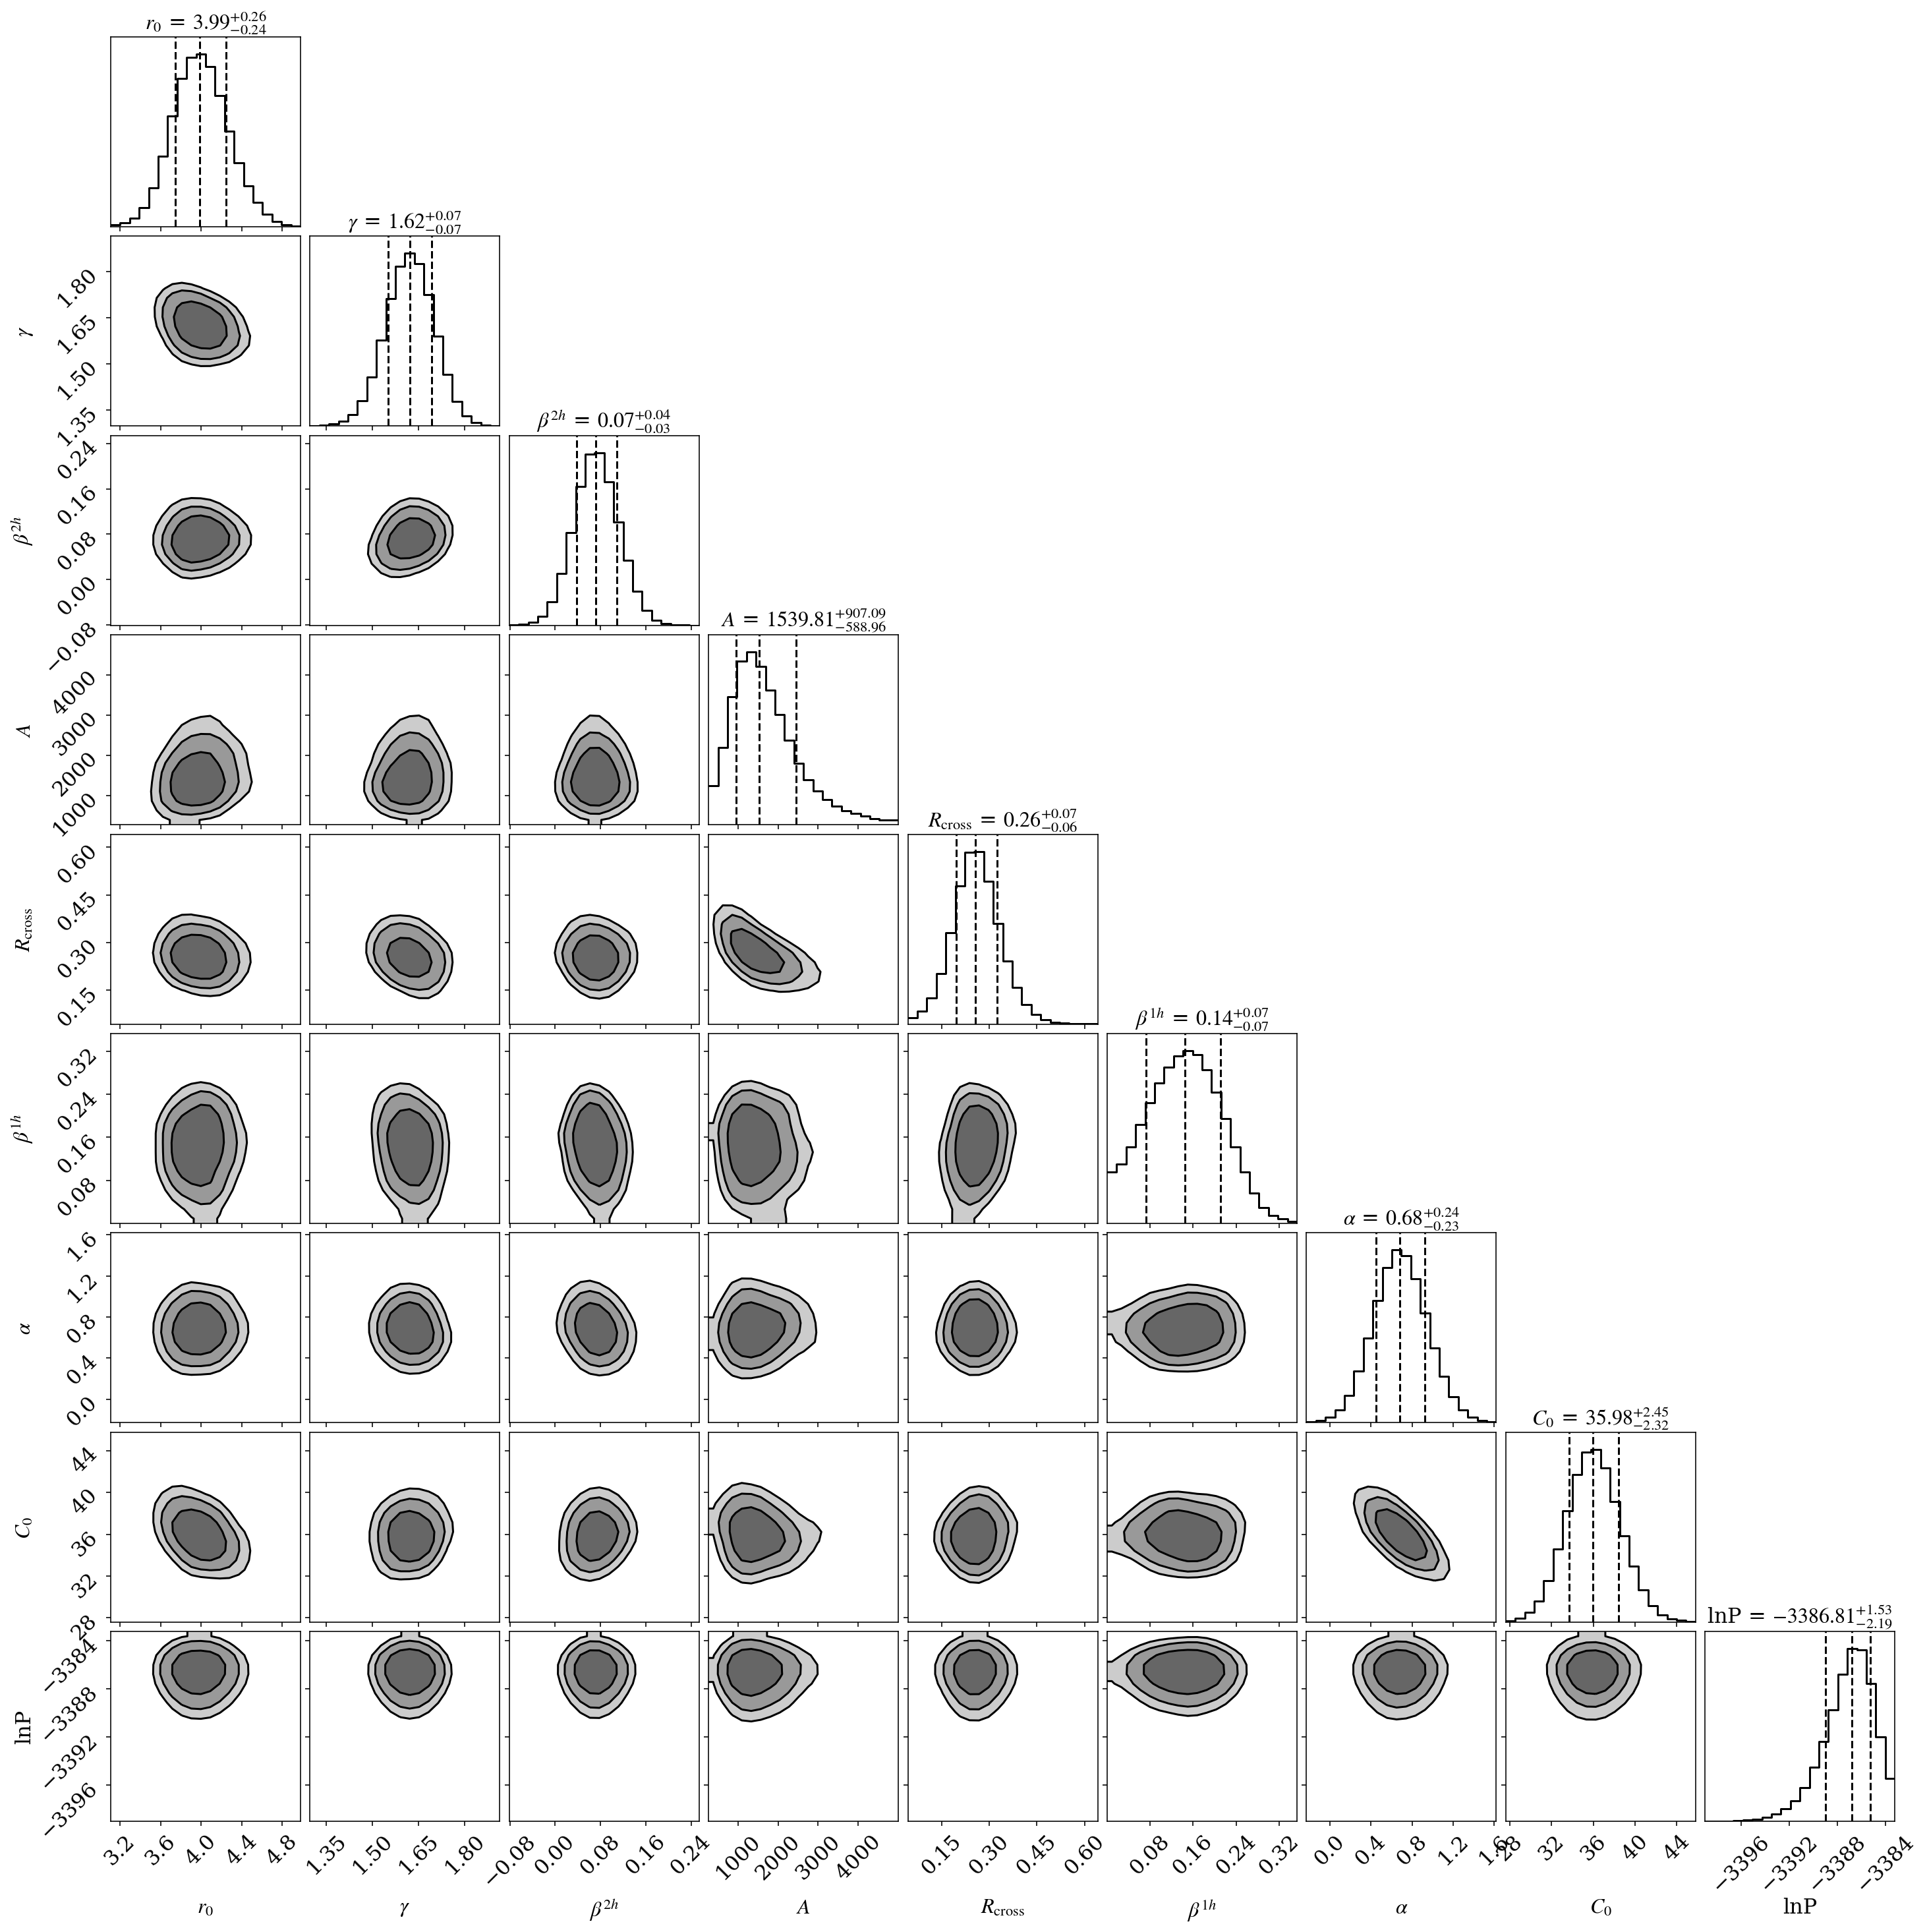

In [12]:

lnprob = sampler.lnprobability[:,discard:].ravel()
flt_w_likelihood = np.concatenate([flat_samples, lnprob[:, None]], axis=1)


levels = (0, 1-np.exp(-0.5), 1-np.exp(-1), 1-np.exp(-1.5))
new_flat = flt_w_likelihood

fig = corner.corner(
    new_flat, labels=labels+['lnP'], levels=levels, quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 16}, 
    smooth=1, smooth1d=1, labelpad=0.1, plot_datapoints=False, plot_density=False,
    fill_contours=True
);
fig.savefig('corner_gauss_1h.png');

In [13]:
import pickle
with open("exclusion_model_gauss_1h_sampler.pkl", "wb") as f:
    pickle.dump(sampler, f)

0.09115496776880981


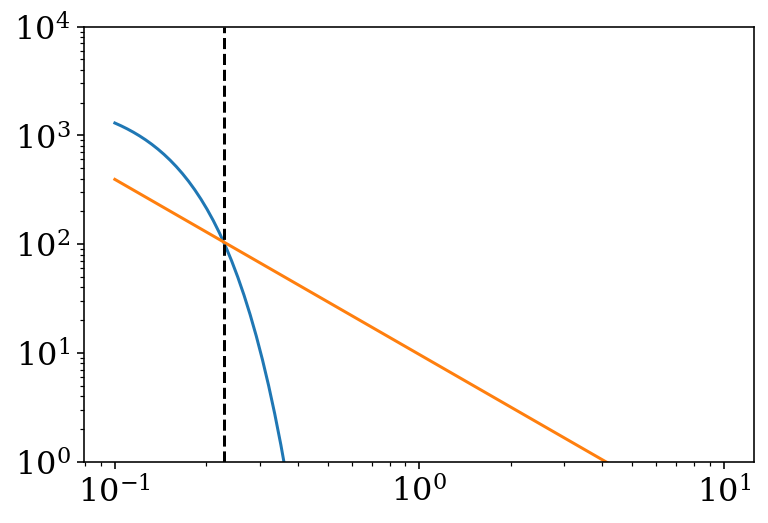

In [14]:
lin = np.geomspace(0.01, 10, 100)

r0, gamma, beta2, A, r_cross, beta1, dndz_index, dndz_coeff = flat_samples[-45]
sig = _calc_sig(r_cross, A, r0, gamma)

plt.plot(rlin, g1h(rlin, A, sig))
plt.plot(rlin, xi2h(rlin, r0, gamma));
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**0, 10**4)
plt.axvline(r_cross,  c="k", ls='--')
print(sig)

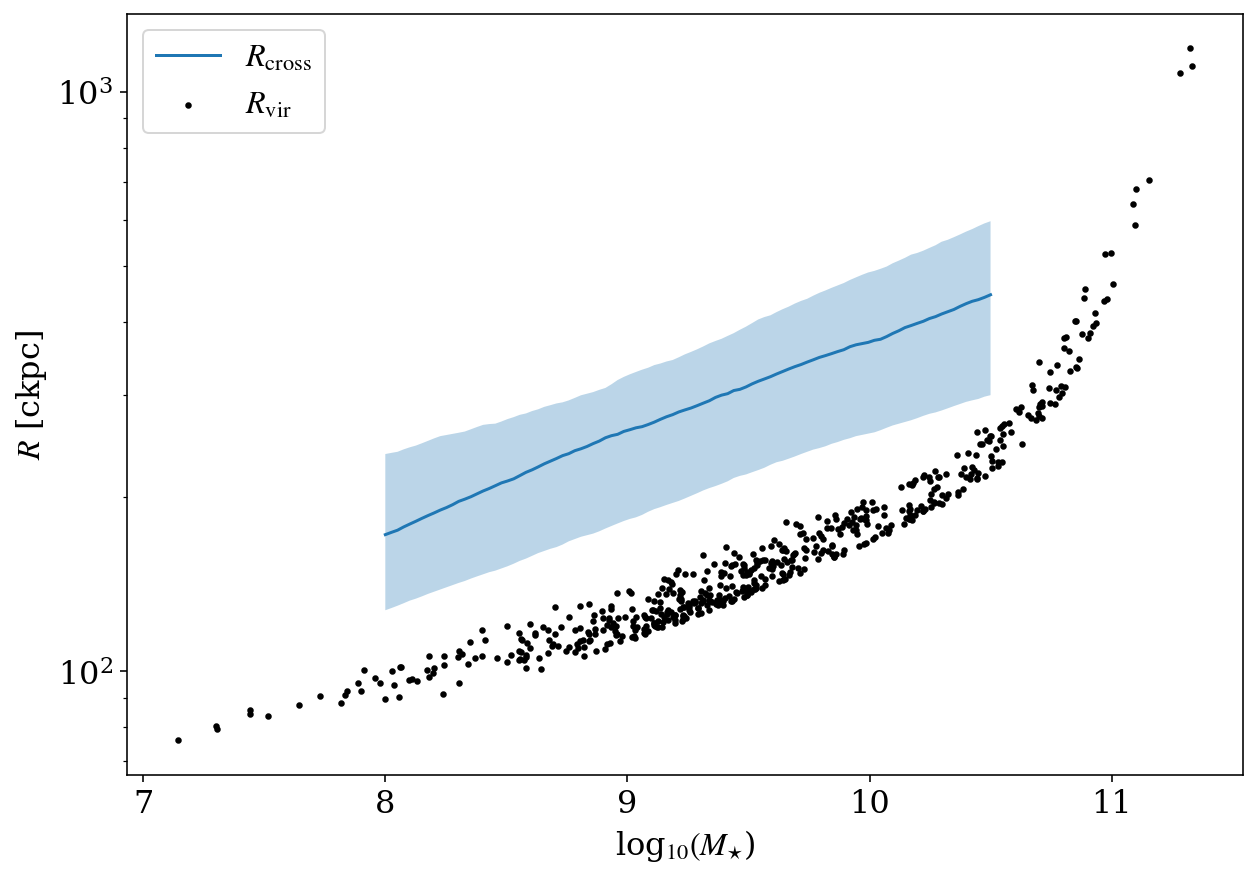

In [15]:
rc = flat_samples[:, 4][::16]
beta = flat_samples[:, 5][::16]
mstars = df.mstars.values[:, None]
mass = np.geomspace(10**8, 10**10.5, 100)[:, None]
m0=10**9.5
z = df.z.values[:, None]

def r_cross_beta(r_cross, beta1h, mass, m0= 10**9.5):
    r_cross = r_cross*(mass/m0) ** beta1h
    return r_cross

rc_m = r_cross_beta(rc, beta, mass, m0)
# kirill: use np.quantile along the mass axis
med, lo, hi = np.quantile(rc_m*1e3, [0.5, 0.16, 0.84], axis=1)


plt.figure(figsize=(10,7))
# plt.plot(np.log10(mass), rc_m*1000, alpha=0.02, c='xkcd:azure');
plt.plot(np.log10(mass), med, alpha=1, c='tab:blue', label=r"$R_{\rm cross}}$");
plt.fill_between(np.log10(mass)[:,0], lo, hi, alpha=0.3)
#plt.fill_between(np.log10(mass)[:,0], lo, hi, alpha=0.3)
plt.scatter(np.log10(mstars), df.rvir.values, s=5, label=r'$R_{\rm vir}$', color='xkcd:black')
plt.xlabel(r"log$_{10}(M_{\star}$)")
plt.ylabel(r"$R$ [ckpc]");
plt.yscale('log')
plt.legend()
plt.savefig("r_cross_mstar.png")

# TODO

r_cross / rvir and take median


In [16]:
rc_m = r_cross_beta(rc, beta, mstars, m0)
med, lo, hi = np.nanquantile(rc_m*1e3/df.rvir.values[:, None], [0.5, 0.16, 0.84])
med, lo, hi

(1.987658791323968, 1.3489310425502883, 2.629911912636269)

TODO:
* run fit on M > 9
* do both to compare
* what fraction of the r cross at a given mass are above Rvir
* mean Rcross as a function of mass power law (mean beta)
* Add a mass dependent amplitude parameter

In [17]:
flat_phit_samps = sampler.get_blobs(flat=True, thin=100)

In [18]:


# get the data for the empirical plots
cgmsqfile = "/Users/mwilde/python/cgm-squared/cgmsquared/data/cgm/cgmsquared_cgmsurvey_aodm_vhalos10_3sigma.json"
casdir = "/Users/mwilde/Dropbox/CASBaH/data/h1_galaxies_20Mpc_500kms_*.fits"
#data_lo = datamodule.get_combined_dataset(cgmsqfile, casdir, M_min=7, M_max=9.204)
#data_mid = datamodule.get_combined_dataset(cgmsqfile, casdir, M_min=9.204, M_max=9.888)
#data_hi = datamodule.get_combined_dataset(cgmsqfile, casdir, M_min=9.888, M_max=17.)
data = datamodule.get_combined_dataset(cgmsqfile, casdir, M_min=7, M_max=12)


read_sets: Using set file -- 
  /Users/mwilde/python/linetools/linetools/lists/sets/llist_v1.3.ascii
Loading abundances from Asplund2009
Abundances are relative by number on a logarithmic scale with H=12
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 1389
misses 5509
Cutting on redshift in hits/misses
Cutting on impact parameter in hits/misses
hits 268
misses 291


In [19]:
flat_phit_samps.shape

(640, 7244)

In [20]:
data[2].shape

(7457,)

In [21]:
bins = np.concatenate([[0.010, 0.05], np.logspace(-1, 1.3, 15)])


def plot_comparison_fc(ax, bins, mass_cut_list, flat_phit_samps, data, masslabel=None):


    # mass for empirical data
    mass_emp = data[2]
    mass_cut_low = mass_cut_list[0]
    mass_cut_hi = mass_cut_list[1]
    mass_model = df.mstars.values
    mass_cut_emp = (mass_emp < 10**mass_cut_hi) & (mass_emp > 10**mass_cut_low)
    mass_cut_model = (mass_model < 10**mass_cut_hi) & (mass_model > 10**mass_cut_low)
    bincenters = (bins[:-1] + bins[1:]) / 2
    rho = df.rho.values[mass_cut_model]

    fc_mod_bin, fc_mod_bin_low, fc_mod_bin_high = hplt.compute_model_fc_bins(rho, flat_phit_samps[:, mass_cut_model], bins)
    cf, lolim, uplim = hplt.compute_empirical_fc_bins(data, bins, mass_cut_emp)

    model = models.Model2hBeta(data=data)
    r_com4 = model.rho_com
    fc4 = datamodule.get_fc_pickle_file("../data/model_2h_only_with_beta_fc.pkl")
    fc_mod_bin4, fc_mod_bin_low4, fc_mod_bin_high4 = hplt.compute_model_fc_bins(
        r_com4[mass_cut_emp], fc4[:, mass_cut_emp], bins
    )

    # plottin stuff
    kwargs = {"elinewidth": 2, "capsize": 5, "lw": 2, "alpha": 1}
    ax.errorbar(
        bincenters,
        cf,
        yerr=[lolim, uplim],
        marker=".",
        color="black",  # fmt='.k',
        ecolor="lightgrey",
        label="data",
        **kwargs,
    )
    ax.errorbar(
        bincenters,
        fc_mod_bin,
        yerr=[fc_mod_bin - fc_mod_bin_low, fc_mod_bin_high - fc_mod_bin],
        marker=".",
        color="tab:blue",
        ecolor="lightblue",
        label=r"Model",
        **kwargs,
    )
    ax.errorbar(
        bincenters,
        fc_mod_bin4,
        yerr=[fc_mod_bin4 - fc_mod_bin_low4, fc_mod_bin_high4 - fc_mod_bin4],
        marker=".",
        color="tab:green",
        ecolor="tab:green",
        label=r"2$^h$ w/ $\beta$",
        **kwargs,
    )
    plt.xscale('log')
    ax.text(0.3, 0.8, masslabel, transform=ax.transAxes)
    ax.set_ylim(0, 1)

    return ax

In [22]:
# mass for empirical data
mass_cut_list = [8, 11]
mass_emp = data[2]
mass_cut_low = mass_cut_list[0]
mass_cut_hi = mass_cut_list[1]
mass_model = df.mstars.values
mass_cut_emp = (mass_emp < 10**mass_cut_hi) & (mass_emp > 10**mass_cut_low)
mass_cut_model = (mass_model < 10**mass_cut_hi) & (mass_model > 10**mass_cut_low)
bincenters = (bins[:-1] + bins[1:]) / 2
rho = df.rho.values[mass_cut_model]

fc_mod_bin, fc_mod_bin_low, fc_mod_bin_high = hplt.compute_model_fc_bins(rho, flat_phit_samps[:, mass_cut_model], bins)
cf, lolim, uplim = hplt.compute_empirical_fc_bins(data, bins, mass_cut_emp)

model = models.Model2hBeta(data=data)
r_com4 = model.rho_com
fc4 = datamodule.get_fc_pickle_file("../data/model_2h_only_with_beta_fc.pkl")
fc_mod_bin4, fc_mod_bin_low4, fc_mod_bin_high4 = hplt.compute_model_fc_bins(
    r_com4[mass_cut_emp], fc4[:, mass_cut_emp], bins
)

In [23]:
# flat_phit_samps[:, mass_cut_model].shape
from scipy.stats import binned_statistic

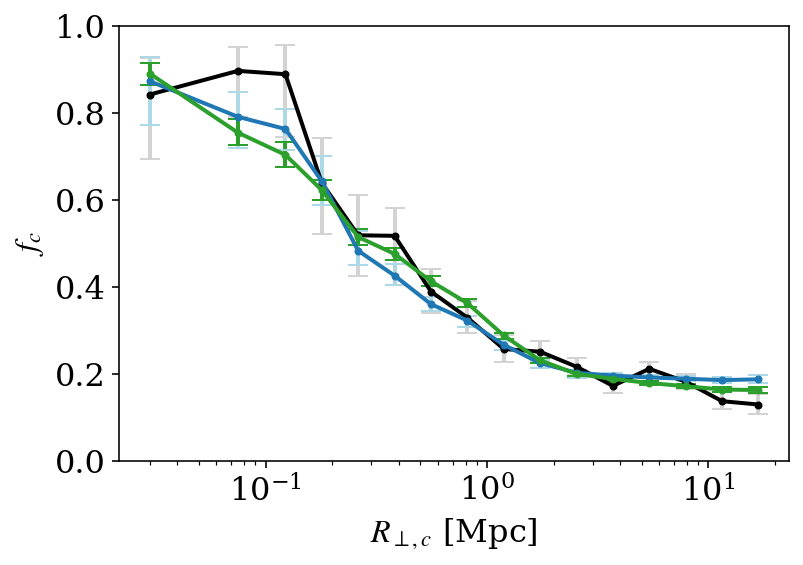

In [24]:
fig, ax = plt.subplots()
mass_cut_list = [8, 11]
ax = plot_comparison_fc(ax, bins, mass_cut_list, flat_phit_samps, data)
ax.set_ylabel(r"$f_c$")
ax.set_xlabel(r"$R_{\perp,c}$ [Mpc]");

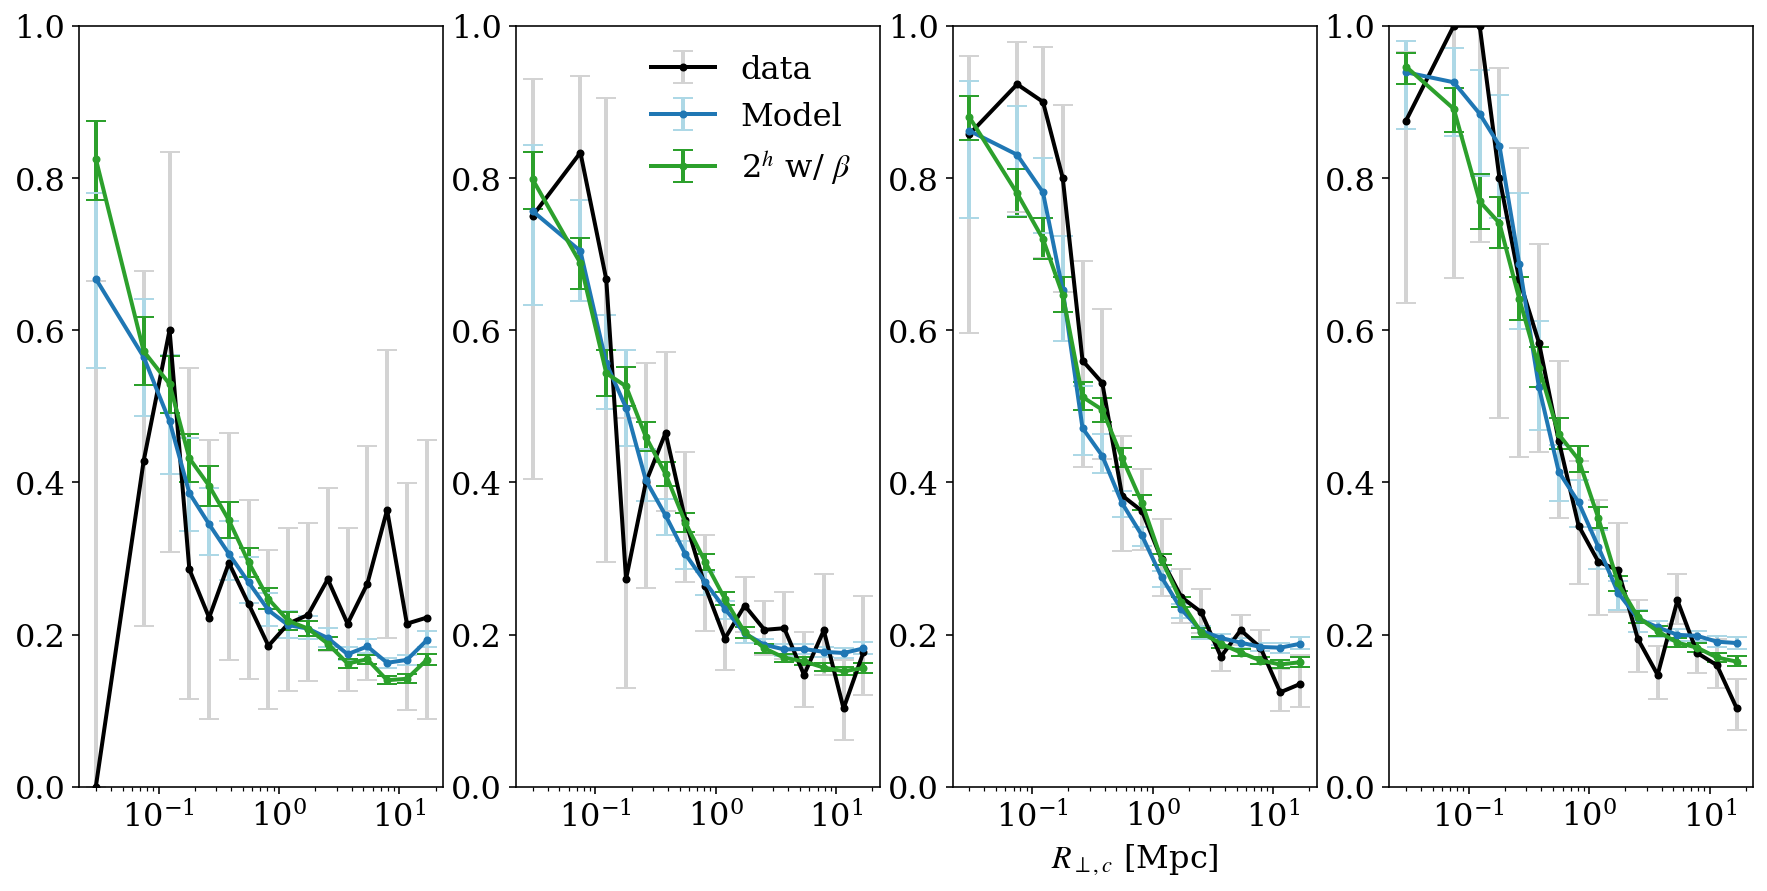

In [25]:
mass_cut_1 = [7, 8]
mass_cut_2 = [8 , 9]
mass_cut_3 = [9, 10]
mass_cut_4 = [10, 11]

fig, axes = plt.subplots(ncols=4, nrows=1, sharex=True, figsize=(15, 7))
axes[0] = plot_comparison_fc(axes[0], bins, mass_cut_1, flat_phit_samps, data, r"")
axes[1] = plot_comparison_fc(axes[1], bins, mass_cut_2, flat_phit_samps, data, r"")
axes[2] = plot_comparison_fc(axes[2], bins, mass_cut_3, flat_phit_samps, data, r"")
axes[3] = plot_comparison_fc(axes[3], bins, mass_cut_4, flat_phit_samps, data, r"")
axes[1].legend(frameon=False)
axes[2].set_xlabel(r"$R_{\perp,c}$ [Mpc]")
fig.subplots_adjust(hspace=0.1)
fig.savefig("model_comparison_mass.png")

# plots for paper

* z vs impact parameter & mass redshift 
* Motivate need for the modelling Fig 14 from Wilde at all
* C Locchaas et all plot, relating r0 to the mass bias $c_0 b_g b_{HI}$ ?
* Covering Fraction plots Kirills plot
* R_cross, fraction above Rvir, 
* Fraction above and also how far from Rvir 
